# Names: 
- Julia Krumgant 40566465
- Pranav Mehta 19184282
- Jules Liu 96285697
- Bingyi Ding 53408571

## Q1

### Algebraic formulation of the problem

$$\begin{array}{rll}
 \text{max} & 7(TotalT - extraT) + 5(TotalC-extraC) + 3extraT+ 4extraC \\
 \\
  \text{s.t.} 
& 3TotalT + 4TotalC \le 2400 \\
 & 2TotalT + TotalC \le 1000 \\
  & extraT \ge TotalT - 150 \\
  & extraC \ge TotalT - 300 \\
  &  TotalC \le 450 \\
   & TotalT  \ge 100 \\
 & \text{non-negativity constraints} : extraT, extraC, TotalT, TotalC ≥ 0 \\\\
\end{array}
$$


Set parameter PoolSolutions to value 35
Set parameter PoolSearchMode to value 2
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x429d678a
Variable types: 0 continuous, 4 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+03]
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 8 nonzeros
Variable types: 0 continuous, 4 integer (0 binary)
Found heuristic solution: objective 700.0000000

Root relaxation: objective 3.300000e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

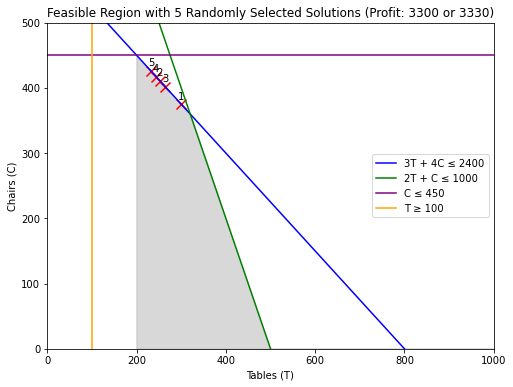

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import random

# Define constraint functions
def capacity_constraint(T):
    return (2400 - 3 * T) / 4

def time_constraint(T):
    return 1000 - 2 * T

# Create a new model
model = gp.Model("Flair Furniture Optimization")

# Variables for Total T and C (changed to integers)
T = model.addVar(vtype=GRB.INTEGER, name="T", lb=0)
C = model.addVar(vtype=GRB.INTEGER, name="C", lb=0)

# Auxiliary variables for Extra T and C production (changed to integers)
extra_t = model.addVar(vtype=GRB.INTEGER, name="Extra_T", lb=0)
extra_c = model.addVar(vtype=GRB.INTEGER, name="Extra_C", lb=0)

# Set the objective function: Maximize profit
profit = (7 * (T - extra_t)) + (5 * (C - extra_c)) + (3 * extra_t) + (4 * extra_c)
model.setObjective(profit, GRB.MAXIMIZE)

# Constraints
model.addConstr(3 * T + 4 * C <= 2400, "Capacity Constraint")
model.addConstr(2 * T + C <= 1000, "Time Constraint")
model.addConstr(C <= 450, "Max Chairs Constraint")
model.addConstr(T >= 100, "Min Tables Constraint")
model.addConstr(extra_t >= T - 150, "Extra_T_Constraint_Positive")
model.addConstr(extra_t >= 0, "Extra_T_NonNegative")
model.addConstr(extra_c >= C - 300, "Extra_C_Constraint_Positive")
model.addConstr(extra_c >= 0, "Extra_C_NonNegative")

# Set parameters to find multiple solutions
model.setParam(GRB.Param.PoolSolutions, 35)
model.setParam(GRB.Param.PoolSearchMode, 2)
model.setParam(GRB.Param.MIPGap, 0)

# Optimize the model
model.optimize()

# Prepare to store solutions
solutions = []

# Check and print solutions
if model.status == GRB.OPTIMAL or model.status == GRB.INTERRUPTED:
    solution_count = model.SolCount
    print(f"\nTotal number of feasible integer solutions found: {solution_count}\n")
    
    for i in range(solution_count):
        model.setParam(GRB.Param.SolutionNumber, i)
        T_val = model.getVarByName('T').Xn
        C_val = model.getVarByName('C').Xn
        obj_val = model.PoolObjVal  # Get the profit for this solution
        
        # Store solution details
        solutions.append({"T": T_val, "C": C_val, "Profit": obj_val})
        
    # Print all solutions
    for idx, sol in enumerate(solutions):
        print(f"Solution {idx + 1}: Tables (T) = {sol['T']}, Chairs (C) = {sol['C']}, Profit = {sol['Profit']:.2f}")

else:
    print("No optimal solution found or model was interrupted.")

# Filter solutions with profit equal to 3300 or 3330
filtered_solutions = [sol for sol in solutions if sol['Profit'] in [3300, 3330]]

# Check if there are any solutions with profit of 3300 or 3330
if not filtered_solutions:
    print("\nNo solutions found with a profit of 3300 or 3330.")
else:
    # Print the filtered solutions
    print("\nFiltered solutions with a profit of 3300 or 3330:")
    for idx, sol in enumerate(filtered_solutions):
        print(f"Solution {idx + 1}: Tables (T) = {sol['T']}, Chairs (C) = {sol['C']}, Profit = {sol['Profit']:.2f}")
    
    # Select 5 random solutions from the filtered solutions
    if len(filtered_solutions) > 5:
        selected_solutions = random.sample(filtered_solutions, 5)
    else:
        selected_solutions = filtered_solutions

    # Now, plot the feasible region with numbered annotations for selected solutions
    T_vals = np.linspace(0, 1000, 500)
    C_capacity = capacity_constraint(T_vals)
    C_time = time_constraint(T_vals)
    max_chairs_constraint = 450
    min_tables_constraint = 100

    # Prepare the plot
    plt.figure(figsize=(8, 6))

    # Plot the constraints
    plt.plot(T_vals, C_capacity, label="3T + 4C ≤ 2400", color="blue")
    plt.plot(T_vals, C_time, label="2T + C ≤ 1000", color="green")
    plt.axhline(y=max_chairs_constraint, color='purple', linestyle='-', label="C ≤ 450")
    plt.axvline(x=min_tables_constraint, color='orange', linestyle='-', label="T ≥ 100")

    # Fill the feasible region
    plt.fill_between(T_vals, 0, np.minimum(C_capacity, C_time), 
                     where=(T_vals >= min_tables_constraint) & (np.minimum(C_capacity, C_time) <= max_chairs_constraint), 
                     color='gray', alpha=0.3)

    # Extract values for plotting the selected solutions
    T_vals_sol = [sol['T'] for sol in selected_solutions]
    C_vals_sol = [sol['C'] for sol in selected_solutions]

    # Plot the selected solutions as crosses
    plt.scatter(T_vals_sol, C_vals_sol, color='red', s=100, marker='x')

    # Annotate the solutions with numbers
    for i, sol in enumerate(selected_solutions):
        plt.annotate(f'{i+1}', (sol['T'], sol['C']), textcoords="offset points", xytext=(0, 5), ha='center')

    # Aesthetics
    plt.xlim(0, 1000)
    plt.ylim(0, 500)
    plt.xlabel('Tables (T)')
    plt.ylabel('Chairs (C)')
    plt.title('Feasible Region with 5 Randomly Selected Solutions (Profit: 3300 or 3330)')
    plt.legend()

    # Show the plot
    plt.show()

Discussion:

Compared to the initial problem that yielded only one solution (the baseline solution), the solver identified 31 feasible integer solutions under the new constraints, all achieving the maximum possible profit of 3300, with 3 additional solutions slightly below that at 3299. For instance, in the first solution, 200 tables and 450 chairs were produced at standard profit margins, while 50 additional tables and 150 additional chairs were produced at lower profit margins, resulting in a total profit of 3300. As shown in the graph, the objective function appears not only to intersect two constraints (carpentry and painting hours) but also seems to align with one of the constraints (3T + 4C ≤ 2400), resulting in multiple optimal solutions along this boundary of the feasible region.



## Q2

### Algebraic formulation of the problem

$$\begin{array}{rll}
 \text{Min} & U_1 + 1O_1 + 5U_2+ O2 + 100U_3+ O_3 \\
 \\
  \text{s.t.} 
  & 3000T + 800R+ 250N + U_1 – O_1= 25000 \\
  & 1000T + 500R + 200N + U_2 – O_2= 30000 \\
  & T + U_3 - O_3 = 10 \\
  & \text{non-negativity constraints} : T, R, N, U_1, O_1, U_2, O_2, U_3, O_ 3 ≥ 0 \\\\
\end{array}
$$


In [6]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
model = gp.Model("Advertising_Optimization")

# Decision variables
T = model.addVar(vtype=GRB.CONTINUOUS, name="T", lb=0)  # Number of TV ads
R = model.addVar(vtype=GRB.CONTINUOUS, name="R", lb=0)  # Number of Radio ads
N = model.addVar(vtype=GRB.CONTINUOUS, name="N", lb=0)  # Number of Newspaper ads

# Under/Over-achievement variables
U1 = model.addVar(vtype=GRB.CONTINUOUS, name="U1", lb=0)  # Under-budget
O1 = model.addVar(vtype=GRB.CONTINUOUS, name="O1", lb=0)  # Over-budget
U2 = model.addVar(vtype=GRB.CONTINUOUS, name="U2", lb=0)  # Under-reaching potential customers
O2 = model.addVar(vtype=GRB.CONTINUOUS, name="O2", lb=0)  # Over-reaching potential customers
U3 = model.addVar(vtype=GRB.CONTINUOUS, name="U3", lb=0)  # Under-achieve TV ads
O3 = model.addVar(vtype=GRB.CONTINUOUS, name="O3", lb=0)  # Over-achieve TV ads

# Set objective function
model.setObjective(
    U1 + O1 + 5 * U2 + O2 + 100 * U3 + O3, GRB.MINIMIZE
)

# Add constraints

# Budget constraint: 3000T + 800R + 250N + U1 - O1 = 25,000
model.addConstr(3000 * T + 800 * R + 250 * N + U1 - O1 == 25000, "Budget")

# Customer reach constraint: 1000T + 500R + 200N + U2 - O2 = 30,000
model.addConstr(1000 * T + 500 * R + 200 * N + U2 - O2 == 30000, "CustomerReach")

# TV ad constraint: T + U3 - O3 = 10
model.addConstr(T + U3 - O3 == 10, "TVAds")

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print(f"Optimal solution found:\n")
    print(f"Number of TV ads: {T.x}")
    print(f"Number of Radio ads: {R.x}")
    print(f"Number of Newspaper ads: {N.x}")
    print(f"Under budget penalty: {U1.x}")
    print(f"Over budget penalty: {O1.x}")
    print(f"Under customer reach penalty: {U2.x}")
    print(f"Over customer reach penalty: {O2.x}")
    print(f"Under TV ads penalty: {U3.x}")
    print(f"Over TV ads penalty: {O3.x}")
else:
    print("No optimal solution found.")



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5825U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3 rows, 9 columns and 13 nonzeros
Model fingerprint: 0xfa47b84e
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+04]
Presolve removed 0 rows and 2 columns
Presolve time: 0.01s
Presolved: 3 rows, 7 columns, 11 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.031250e+02   0.000000e+00      0s
       4    1.3500000e+04   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.350000000e+04
Optimal solution found:

Number of TV ads: 0.0
Number of Radio ads: 0.0
Number of Newspaper ads: 150.0
Under budget penal

Solution discussion: 

Newspaper ads are the most cost-effective option, though their reach per ad is significantly smaller compared to other channels. Using only newspaper ads would be the most efficient strategy.

Discussion of penalties:

Budget and customer reach penalties:
We have an estimated budget of `$25,000`, with a penalty of `$1` for every dollar spent over the limit. In contrast, the customer reach penalty is much more significant. We aim to reach 30,000 potential customers, only 5,000 more than our budgeted reach of 25,000, but for each customer short of this goal, the penalty is `$5`. Given that the customer reach penalty is much more severe than the budget penalty, we are inclined to incur the full budget penalty if needed.

TV ad penalty:
Compared to radio and newspaper, television ads are less cost-effective in terms of reach per dollar. While the primary reason for running TV ads is to avoid penalties, the cost of TV ads is very high. Each TV ad costs `$3,000` and reaches only 1,000 customers, while a similar reach through newspaper ads would cost just `$1,250`. The difference of `$1,750` far exceeds the `$100` penalty for reducing one TV ad. Therefore, Therefore, we could easily accept the penalty and choose not to run any TV ads at all.